In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
torch.manual_seed(1337)
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# if device == 'cuda':
#     print('GPU:', torch.cuda.get_device_properties(0).name)
# else:
#     print("CPU")

In [3]:
with open("./tinyShakesphere.txt", "r", encoding="utf-8") as file:
    text = file.read()

In [4]:
chars = sorted(set(text))
vocab_size = len(chars) 
print(''.join(chars))
print(len(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [6]:
encoded_text = torch.tensor(encode(text), dtype=torch.long)

In [7]:
train_size = 0.9

train_data = encoded_text[:int(train_size*len(encoded_text))]
val_data = encoded_text[int(train_size*len(encoded_text)):]

In [8]:
batch_size = 4
block_size = 8
max_iters = 5000
eval_interval = 500
lr = 1e-3
eval_iters = 100
n_embed = 32
n_heads = 4
n_layers = 3
dropout = 0.2

In [9]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device=device), y.to(device=device)

In [10]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size,device=device)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out

        

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed//num_heads) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

In [12]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [13]:
class Block(nn.Module):
    def __init__(self, n_embed, num_heads):
        super().__init__()
        self.head = MultiHeadAttention(num_heads)
        self.ff = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    def forward(self, x):
        x = x + self.head(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

In [14]:
class GPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed, num_heads=n_heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)
        
    
    def forward(self, idx, targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T, n_embed)
        pos_emb = self.position_embedding_table(torch.arange(T)) #(T, C)
        x = tok_emb + pos_emb # (B,T, C)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits =  self.lm_head(x) # (B,T, vocab_size)
        if targets is None:
            loss = None
        else: 
            B, T, C =  logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:,-block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:] # (B, C)
            probs = F.softmax(logits, dim=1) # (B, C)
            idx_next = torch.multinomial(probs,num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
 

In [15]:
gpt = GPT()
# gpt = torch.compile(gpt)

In [16]:
sum(p.numel() for p in gpt.parameters())

44193

In [17]:
optimizer = optim.AdamW(gpt.parameters(), lr=lr)

In [18]:
@torch.no_grad()
def estimate_loss(model, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x,y = get_batch(split)
            logits, loss = model(x,y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [19]:
train_loss = []
val_loss = []
step = []

In [23]:
for steps in tqdm(range(5000)):
    if steps % eval_iters == 0:
        losses = estimate_loss(gpt, eval_iters)
        print(f'step {steps}: train loss {losses['train']:.4f}, test loss {losses['val']:.4f}')
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        step.append(step[-1] + eval_iters if step else eval_iters)
    xb, yb = get_batch(train_data)
    logits, loss = gpt(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

step 0: train loss 2.4065, test loss 2.1595
step 100: train loss 2.3936, test loss 2.1808
step 200: train loss 2.4138, test loss 2.1516
step 300: train loss 2.4045, test loss 2.1601
step 400: train loss 2.3627, test loss 2.1458
step 500: train loss 2.3653, test loss 2.0869
step 600: train loss 2.4493, test loss 2.1468
step 700: train loss 2.3496, test loss 2.1401
step 800: train loss 2.3911, test loss 2.1433
step 900: train loss 2.3569, test loss 2.1262
2.2595651149749756


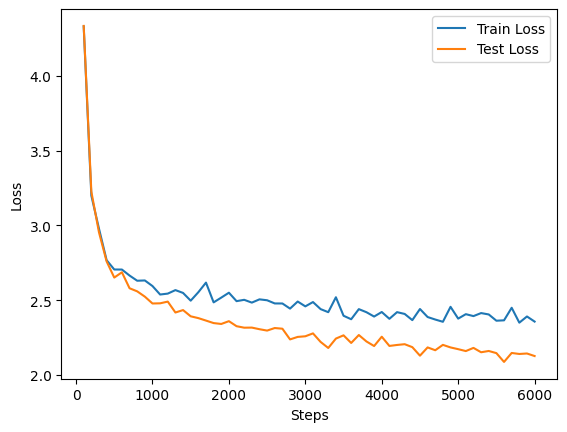

In [24]:
plt.plot(step, train_loss, label='Train Loss')
plt.plot(step, val_loss, label='Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
print(decode(gpt.generate(torch.tensor([[0]], dtype=torch.long,device=device), max_new_tokens=1000)[0].tolist()))


Py beine sus;
A me Braunght
To ness, Pe.

TMadcyshiss,
I Ran nome hap tofes cop gad deithee my not sest?

Pe rubain springiess an thine
:
Pe whateome?
Hish tom.

We lamave nome.

Lof mre briw:
Bhin I ilk sur be ve ose.

PROSPERTIS:
Noty,
Meth lid shesing noom an you gon kre velith thisth is reginN mut mand ant atae neres aring gith bye wour and unts, in stre the IrupyouLesir no mino now yough.

PoCSTIO:
BeT chodainiin pine of thea wawthisif tou so oI ste briegrdon se thhe ind munhas a tbry heas is thet anto iys a ang shrebe geaught fing Pit they sur hou my,
Sy till tham nill ent
bour ipre buaye?

ASTINAN:
Araid ar be Peaar prike pray tooh henie an of an er-ane, I na.
Ne avink wunten der ontris bon man ble kd brelle
bant: lie not in

Thot arke wit pierene wisib'
Thind haalll your the ust beal fe ple griakth bind nonet the's
A then ir shalll, amand catly ha I the what fme the thinen your veam, mis an: that-' this, King gioce an as beise, exe cing el; eats manthen pre the ard inte owsin 